# Homework 3: RNN Language Model

## 1A. Description and Illustration of RNN Language Model architecture and design choices

The RNN language model architecture is designed to process sequential data, such as text, and predict the next token in a sequence. The model is implemented using PyTorch and consists of several key components. The `HyperParams` dataclass encapsulates the hyperparameters, including `vocab_size`, `batch_size`, `seq_length`, `learning_rate`, `num_epochs`, `hidden_dim`, `num_layers`, `embedding_dim`, and `dropout`. These parameters are used to configure the model's behavior and structure. The `RNN` class inherits from `nn.Module` and defines the model's architecture. It includes an embedding layer (`nn.Embedding`) to convert input tokens into dense vectors of size `embedding_dim`, followed by an RNN layer (`nn.RNN`) with `hidden_dim` units and `num_layers` layers. Dropout (`nn.Dropout`) is applied to the RNN output to prevent overfitting. Finally, a fully connected layer (`nn.Linear`) maps the RNN's hidden state to the output vocabulary space. The `forward` method processes the input sequence, computes embeddings, passes them through the RNN, applies dropout, and generates logits for the next token prediction. The model also maintains a hidden state, which is updated at each time step to capture sequential dependencies.

## 1B. Model Hyperparameters

    vocab_size=10000,
    batch_size=64,
    seq_length=30,
    learning_rate=0.0005,
    num_epochs=20,
    hidden_dim=256,
    num_layers=1,
    embedding_dim=100,
    dropout=0

## 1C. Learning Curves

![alt text](<Experiment 0/loss_curve.png>)

![alt text](<Experiment 0/perplexity_curve.png>)

## 1D. Final Test Set Perplexity

## 2. Improving the RNN language model architecture

To improve upon vanilla RNNs wer can use advanced RNN variants, attention mechanisms, and regularization. Some examples of these are below:

- LSTM (Long Short-Term Memory): Replace the vanilla RNN with LSTM cells, which are better at capturing long-term dependencies due to their gating mechanisms (input, forget, and output gates).

- GRU (Gated Recurrent Unit): Use GRUs, which are a simpler alternative to LSTMs but still effective at handling long-term dependencies with fewer parameters.

- Bidirectional RNNs: Implement bidirectional RNNs to capture context from both past and future tokens, which is particularly useful for tasks like text generation or sentiment analysis.

- Self-Attention: Incorporate self-attention mechanisms (as used in Transformers) to allow the model to focus on relevant parts of the input sequence, improving its ability to handle long-range dependencies.

- Layer Normalization: Apply layer normalization to stabilize training and improve convergence.

- Learning Rate Scheduling: Use learning rate schedulers (e.g., cosine annealing or step decay) to adaptively adjust the learning rate during training.

In [26]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import os
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import Counter
import math

### Hyperparams and RNN

In [27]:
@dataclass
class HyperParams:
    '''Dataclass to store hyperparameters for the RNN Language Model'''

    vocab_size: int
    batch_size: int
    seq_length: int
    learning_rate: float
    num_epochs: int
    hidden_dim: int
    num_layers: int
    embedding_dim: int
    dropout: float

    def __hash__(self):
        return hash(
            (
                self.vocab_size,
                self.batch_size,
                self.seq_length,
                self.learning_rate,
                self.num_epochs,
                self.hidden_dim,
                self.num_layers,
                self.embedding_dim,
                self.dropout
            )
        )

    def __eq__(self, value: 'HyperParams'):
        return (
            self.vocab_size == value.vocab_size
            and self.batch_size == value.batch_size
            and self.seq_length == value.seq_length
            and self.learning_rate == value.learning_rate
            and self.num_epochs == value.num_epochs
            and self.hidden_dim == value.hidden_dim
            and self.num_layers == value.num_layers
            and self.embedding_dim == value.embedding_dim
            and self.dropout == value.dropout
        )

    def __repr__(self):
        return f'HP(vocab_size={self.vocab_size}, batch_size={self.batch_size}, seq_len={self.seq_length}, lr={self.learning_rate}, epochs={self.num_epochs}, hl_dim={self.hidden_dim}, num_layers={self.num_layers}, emb_dim={self.embedding_dim}, do={self.dropout})'


class RNN(nn.Module):
    def __init__(self, hp: HyperParams):
        super().__init__()  # Remove 'self' from super() call
        self.HP = hp
        # Embedding layer
        self.embedding = nn.Embedding(hp.vocab_size, hp.embedding_dim)
        # RNN layers
        self.rnn = nn.RNN(
            input_size=hp.embedding_dim,
            hidden_size=hp.hidden_dim,
            num_layers=hp.num_layers,
            batch_first=True,
            dropout=hp.dropout
        )
        # Dropout layer
        self.dropout = nn.Dropout(hp.dropout)
        # Output layer
        self.fc = nn.Linear(hp.hidden_dim, hp.vocab_size)

    def forward(self, x, hidden):
        # Embed the input
        embedded = self.embedding(x)
        # Pass through RNN
        rnn_out, hidden = self.rnn(embedded, hidden)
        # Take the last time step and pass through final layer
        logits = self.dropout(rnn_out)
        output = self.fc(logits)
        return output, hidden

### RNN LLM Implementation

In [28]:
class RNNLLM:
    def __init__(self, train_valid_test_files: tuple[str, str, str], hp: HyperParams):
        self.train_file, self.valid_file, self.test_file = train_valid_test_files
        self.HP = hp
        os.environ['CUDA_LAUNCH_BLOCKING']="1"
        os.environ['TORCH_USE_CUDA_DSA'] = "1"
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        print(f'Using Torch device: {self.device}')

    def train_models(self, hyperparams: list[HyperParams]):
        hp_to_loss: dict[HyperParams, tuple[float, float, float]] = {}
        # Each value in the dict is a tuple of (valid loss, test_loss, perplexity)
        print(f'Evaluating {len(hyperparams)} hyperparameter configurations')
        for i, hp in enumerate(hyperparams):
            print(f'Evaluating HP {i+1}/{len(hyperparams)}')
            self.HP = hp
            self.train(debug=False, exp_id=i)
            valid_loss, valid_perplexity = self.evaluate(self.valid_loader)
            test_loss, test_perplexity = self.evaluate(self.test_loader)
            hp_to_loss[hp] = (valid_loss, test_loss, valid_perplexity)
        return hp_to_loss

    def evaluate(self, data_loader):
        self.model.eval()
        hidden = self.init_hidden_layer(
            self.HP.num_layers, self.HP.batch_size, self.HP.hidden_dim
        )
        total_loss = 0.0
        total_samples = 0
        with torch.no_grad():
            for x, y in data_loader:
                x, y = x.to(self.device), y.to(self.device)
                actual_batch_size = x.size(0)
                if hidden.size(1) != actual_batch_size:
                    hidden = self.init_hidden_layer(
                        self.HP.num_layers, actual_batch_size, self.HP.hidden_dim
                    )
                # hidden = hidden.detach()
                output, hidden = self.model(x, hidden)
                loss = self.loss_func(
                    output.view(-1, self.HP.vocab_size), y.view(-1))
                total_loss += loss.item()
                total_samples += actual_batch_size
        # total_samples = len(data_loader.dataset) #* self.HP.batch_size
        avg_loss = total_loss / total_samples
        perplexity = math.exp(avg_loss) if avg_loss < 100 else float('inf') # Prevent overflow
        return avg_loss, perplexity

    def load_model(self, exp_dir: str):
        model_weights_path = os.path.join(exp_dir, 'model_weights.pth')
        hp_pickle_path = os.path.join(exp_dir, f'HP_{self.HP.__hash__()}.pkl')
        if os.path.exists(hp_pickle_path):
            with open(hp_pickle_path, 'rb') as f:
                stored_hp = pickle.load(f)
                if stored_hp == self.HP:
                    print(
                        f'Found existing model with the same hyperparameters: {self.HP}')
                return True
        return False

    def train(self, debug=True, exp_id: int = -1):
        # Before training, if we've already trained a model
        # with the exact same hyperparameters, we can load it instead of training
        self.setup_training_data()
        self.setup_training_model()
        if exp_id == -1:
            exp_id = datetime.now().strftime('%Y%m%d_%H%M%S')
        # Create experiment folder
        experiment_folder = f'Experiment {exp_id}'
        os.makedirs(experiment_folder, exist_ok=True)
        if (self.load_model(experiment_folder)):
            print(f'Skipping training for model: {self.HP}')
            return
        train_losses = []
        train_perplexities = []
        valid_losses = []
        valid_perplexities = []
        start_time = time.time()
        for e in range(self.HP.num_epochs):
            print(f"Epoch {e+1}/{self.HP.num_epochs}") if debug else None
            # Initialize hidden layers on every epoch
            hidden = self.init_hidden_layer(
                self.HP.num_layers, self.HP.batch_size, self.HP.hidden_dim
            )
            epoch_loss = 0.0
            for batch_idx, (x, y) in enumerate(self.train_loader):
                self.model.train()
                x, y = x.to(self.device), y.to(self.device)
                actual_batch_size = x.size(0)
                # Adjust the hidden state to match the actual batch size
                if hidden.size(1) != actual_batch_size:
                    hidden = self.init_hidden_layer(
                        self.HP.num_layers, actual_batch_size, self.HP.hidden_dim
                    )
                print(
                    f"Processing batch {batch_idx + 1}/{len(self.train_loader)}"
                ) if debug else None
                self.optimizer.zero_grad()
                output, hidden = self.model(x, hidden)
                loss = self.loss_func(
                    output.view(-1, self.HP.vocab_size), y.view(-1)
                )
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(), max_norm=1)  # Clipping
                self.optimizer.step()
                # Prevent backprop through time?
                hidden = hidden.detach()
                epoch_loss += loss.item()
                print(
                    f"Batch {batch_idx + 1}/{len(self.train_loader)}, Loss: {loss.item()}"
                ) if debug else None
                # End of batch loop
            avg_epoch_loss = epoch_loss / len(self.train_loader)
            epoch_perplexity = math.exp(avg_epoch_loss)
            train_perplexities.append(epoch_perplexity)
            train_losses.append(avg_epoch_loss)

            # Validation loss
            valid_loss, valid_perplexity = self.evaluate(self.valid_loader)
            valid_losses.append(valid_loss)
            valid_perplexities.append(valid_perplexity)
            print(
                f"Epoch {e+1}/{self.HP.num_epochs} Train Loss: {avg_epoch_loss}, Valid Loss: {valid_loss} Train Perplexity: {epoch_perplexity} Valid Perplexity: {valid_perplexity}"
            )
            # End of epoch loop
        end_time = time.time()
        train_time_seconds = end_time - start_time
        train_time_minutes = train_time_seconds / 60
        train_time_hours = int(train_time_seconds // 3600)
        train_time_minutes = int((train_time_seconds % 3600) // 60)
        train_time_seconds = int(train_time_seconds % 60)
        train_time_str = f'{train_time_hours:02d}:{train_time_minutes:02d}:{train_time_seconds:02d}'
        print(
            f'Training took {train_time_str} (HH:MM:SS)'
        )

        # Save the model weights and hyperparameters
        torch.save(self.model.state_dict(), os.path.join(
            experiment_folder, 'model_weights.pth'))

        # Write hyperparameters to a pickle file
        with open(os.path.join(experiment_folder, f'HP_{self.HP.__hash__()}.pkl'), 'wb') as f:
            pickle.dump(self.HP, f)

        # Plot and save loss
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.HP.num_epochs + 1), train_losses,
                 label='Training Loss', marker='o', color='b')
        plt.plot(range(1, self.HP.num_epochs + 1), valid_losses,
                 label='Validation Loss', marker='o', color='r')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.figtext(
            0.15, 0.85, f'Training Time: {train_time_str} (HH::MM::SS)', fontsize=10, ha='left'
        )
        plt.savefig(os.path.join(experiment_folder, f'loss_curve.png'))

        # Plot and save perplexity
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.HP.num_epochs + 1), train_perplexities,
                 label='Training Perplexity', marker='o', color='b')
        plt.plot(range(1, self.HP.num_epochs + 1), valid_perplexities,
                 label='Validation Perplexity', marker='o', color='r')
        plt.xlabel('Epochs')
        plt.ylabel('Perplexity')
        plt.title('Perplexity Curve')
        plt.legend()
        plt.figtext(
            0.15, 0.85, f'Training Time: {train_time_str} (HH::MM::SS)', fontsize=10, ha='left'
        )
        plt.savefig(os.path.join(experiment_folder,
                    f'perplexity_curve.png'))

    def setup_training_model(self):
        print(f'Setting up training model with {self.HP}')
        self.model = RNN(self.HP)
        self.model = self.model.to(self.device)
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(
            self.model.parameters(), lr=self.HP.learning_rate)

    def setup_training_data(self):
        # Load the training data and create a vocabulary mapping
        print(f'Loading data and creating vocabulary')
        self.train_indices, self.train_vocab = self.load_data(self.train_file)
        
        # Create the vocabulary mapping from the training set
        train_text = self.load_wikitext(self.train_file)
        train_tokens = self.tokenize(train_text)
        self.word_to_idx = self.create_vocab_mapping(train_tokens)
        
        # Use the same vocabulary mapping for validation and test sets
        self.valid_indices, self.valid_vocab = self.load_data(self.valid_file, self.word_to_idx)
        self.test_indices, self.test_vocab = self.load_data(self.test_file, self.word_to_idx)

        print(f'Train vocab size: {self.train_vocab}')
        print(f'Valid vocab size: {self.valid_vocab}')
        print(f'Test vocab size: {self.test_vocab}')

        print(f'Creating input-output pairs for the dataset')
        # Create input-output pairs for the dataset
        self.train_inputs, self.train_targets = self.create_sequences(
            self.train_indices, self.HP.seq_length)
        self.valid_inputs, self.valid_targets = self.create_sequences(
            self.valid_indices, self.HP.seq_length)
        self.test_inputs, self.test_targets = self.create_sequences(
            self.test_indices, self.HP.seq_length)

        print(f'Creating TensorDataset and DataLoader objects')
        # Create the TensorDataset objects
        self.train_dataset = TensorDataset(
            self.train_inputs, self.train_targets)
        self.valid_dataset = TensorDataset(
            self.valid_inputs, self.valid_targets)
        self.test_dataset = TensorDataset(self.test_inputs, self.test_targets)

        # Create the DataLoader objects
        self.train_loader = DataLoader(
            self.train_dataset, self.HP.batch_size, shuffle=True)
        self.valid_loader = DataLoader(
            self.valid_dataset, self.HP.batch_size, shuffle=False)
        self.test_loader = DataLoader(
            self.test_dataset, self.HP.batch_size, shuffle=False)

    def init_hidden_layer(self, num_layers, batch_size, hidden_dim):
        return torch.zeros(num_layers, batch_size, hidden_dim).to(self.device)

    def create_sequences(self, data, seq_length):
        inputs = []
        targets = []
        for i in range(0, len(data) - seq_length, seq_length):
            inputs.append(data[i:i + seq_length])  # input sequence
            # target sequence, shifted by one
            targets.append(data[i + 1:i + seq_length + 1])
        return torch.tensor(inputs, dtype=torch.long), torch.tensor(targets, dtype=torch.long)

    def load_wikitext(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read().replace('\n', ' <eol> ')
        return text

    def tokenize(self, text):
        return text.split(' ')

    def create_vocab_mapping(self, tokens, threshold=10):
        counter = Counter(tokens)
        sorted_tokens = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # Keep only the top vocab_size tokens
        sorted_tokens = sorted_tokens[:self.HP.vocab_size - 2]
        # Create a mapping from words to indices
        word_to_idx = {}
        word_to_idx['<unk>'] = 0
        word_to_idx['<eol>'] = 1
        word_index = 2 # Start from 2 and assign indices to words as we travel through the sorted_tokens
        for tkn, cnt in sorted_tokens:
            if cnt >= threshold:
                if tkn and tkn != '<eol>': # skip empty and <eol> tokens
                    word_to_idx[tkn] = word_index
                    word_index += 1
        return word_to_idx

    def tokens_to_indices(self, tokens, word_to_idx):
        # return a list of indices (based on the dict mapping words to tokens)
        return [word_to_idx.get(token, word_to_idx['<unk>']) for token in tokens if token]

    def load_data(self, text, word_to_idx=None):
        data_text = self.load_wikitext(text)
        data_tokens = self.tokenize(data_text)
        if word_to_idx is None:
            # Create a new vocabulary mapping if none is provided
            data_word_to_idx = self.create_vocab_mapping(data_tokens)
        else:
            # Use the provided vocabulary mapping
            data_word_to_idx = word_to_idx
        vocab_size = len(data_word_to_idx)
        data_indices = self.tokens_to_indices(data_tokens, data_word_to_idx)
        return data_indices, vocab_size

### Testing

Using Torch device: cuda
Evaluating 2 hyperparameter configurations
Evaluating HP 1/2
Loading data and creating vocabulary
Train vocab size: 9997
Valid vocab size: 9997
Test vocab size: 9997
Creating input-output pairs for the dataset
Creating TensorDataset and DataLoader objects
Setting up training model with HP(vocab_size=10000, batch_size=64, seq_len=30, lr=0.0005, epochs=20, hl_dim=256, num_layers=1, emb_dim=100, do=0)
Epoch 1/20 Train Loss: 5.741954728084452, Valid Loss: 5.230451040100633 Train Perplexity: 311.6730519916503 Valid Perplexity: 186.87707356822227
Epoch 2/20 Train Loss: 5.167516476529486, Valid Loss: 5.012185017267863 Train Perplexity: 175.47849091910774 Valid Perplexity: 150.23263869196734
Epoch 3/20 Train Loss: 4.951074640102246, Valid Loss: 4.904302793636656 Train Perplexity: 141.3267577463975 Valid Perplexity: 134.8688458020299
Epoch 4/20 Train Loss: 4.8115287773749404, Valid Loss: 4.841366479271336 Train Perplexity: 122.91939033215968 Valid Perplexity: 126.642287

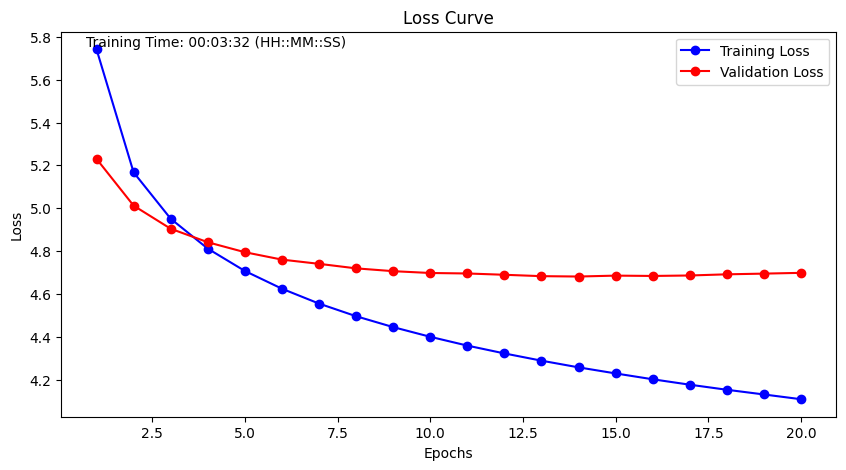

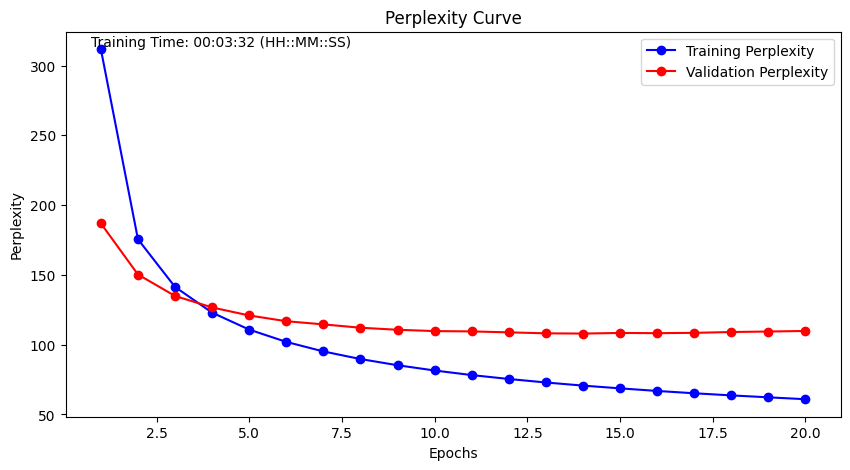

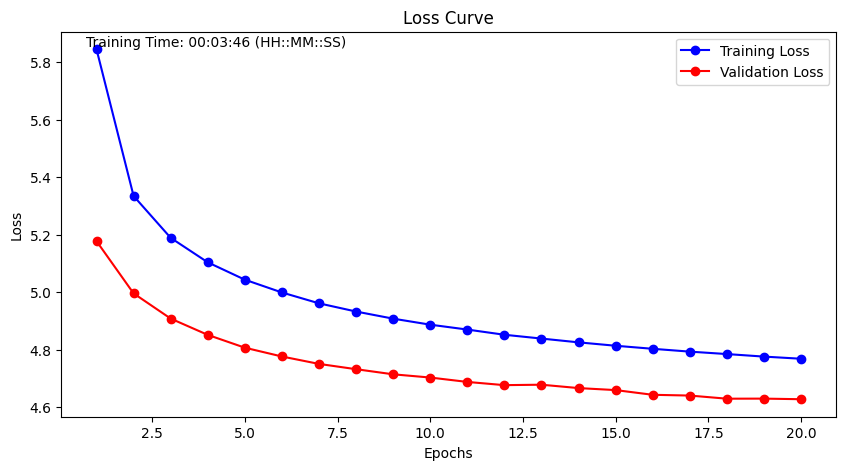

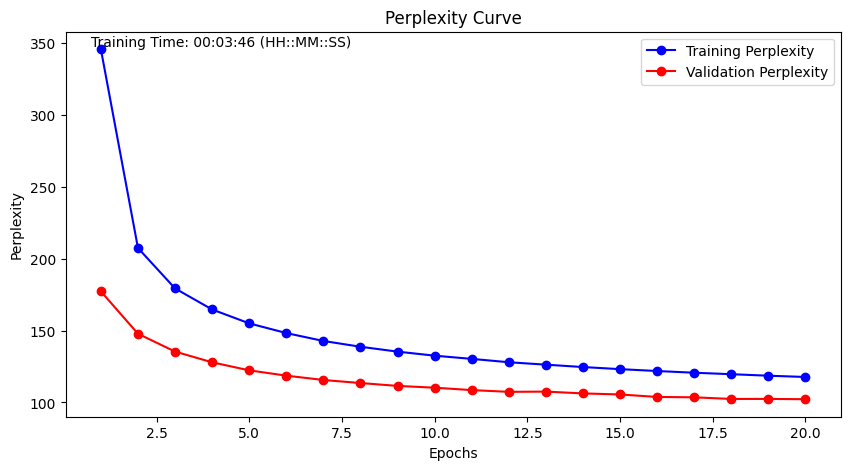

In [29]:
hp = HyperParams(
    vocab_size=10000,
    batch_size=64,
    seq_length=30,
    learning_rate=0.0005,
    num_epochs=20,
    hidden_dim=256,
    num_layers=1,
    embedding_dim=100,
    dropout=0
)
multi_layer_rnn = HyperParams(
    vocab_size=10000,
    batch_size=64,
    seq_length=30,
    learning_rate=0.001,
    num_epochs=20,
    hidden_dim=256,
    num_layers=2,
    embedding_dim=100,
    dropout=0.5
)
rnn_llm = RNNLLM(
    train_valid_test_files=(
        'wiki2.train.txt', 'wiki2.valid.txt', 'wiki2.test.txt'
    ),
    hp=hp
)
# rnn_llm.train(debug=False)
hps = [hp, multi_layer_rnn]
hp_to_loss_map = rnn_llm.train_models(hps)
for hp, (valid_loss, test_loss, valid_perplexity) in hp_to_loss_map.items():
    print('--------------------')
    print(
        f'{hp}\nValidation Loss: {valid_loss}, Test Loss: {test_loss}, Validation Perplexity: {valid_perplexity}'
    )
    print('--------------------')